# Mattermost カスタム絵文字一括登録

---

In [1]:
import os
import unicodedata
import string
import pykakasi
import requests
import json
import io
import math
import shutil
import numpy as np
from time import sleep
from matplotlib import pylab as plt
from PIL import Image, ImageFilter

%matplotlib inline

## 環境変数を設定

In [2]:
# 絵文字格納ディレクトリパス
EMOJI_DIR = './emoji'

# Mattermost URL
BASE_URL = 'Your mattermost url.'
# Mattermost 投稿ユーザーID
USER_ID = 'Emoji create user id.'
# Mattermost アクセストークン
ACCESS_TOKEN = 'Emoji create user access token.'
# Mattermost 投稿チャンネルID
POST_CHANNEL_ID = 'Emoji post channel.'


---

## ディレクトリ内の絵文字一覧リストの作成

絵文字ファイル格納ディレクトリ内のファイルリストを作成します

In [3]:
def listdir(path):
    """ディレクトリ内のファイルの一覧取得"""
    return os.listdir(path=path)

In [4]:
# ローマ字変換ライブラリ
kks = pykakasi.kakasi()

def convert_romaji(s: str) -> str:
    """文字列をローマ字に変換します"""
    # 全角記号を半角記号に
    _s = unicodedata.normalize('NFKC', s)
    # 記号削除
    _s = ''.join([t for t in _s if t not in (f'{string.punctuation}”’−¥〜ー「」、。・')])
    # ローマ字に
    ks = kks.convert(_s)
    # 文字列に
    _k = ''.join([k['passport'] for k in ks])
    # スペースがあり場合「_」に置換して小文字化して返却
    return _k.replace(' ', '_').lower()


In [5]:
def emoji_file_list(filename_list: list[dict[str, str]]) -> list[dict[str, str]]:
    """ファイル名リストのファイル名をローマ字変換してファイル名とローマ字名をキーに持った辞書のリストを返却します"""
    return [{ 'filename': filename, 'romaji_name': f'{convert_romaji("".join(filename.strip().split(".")[:-1]))}' } for filename in filename_list]


---

### ファイル名一覧取得

In [6]:
emoji_filename_list = listdir(EMOJI_DIR)
emoji_filename_list

['1.png',
 '2.png',
 '3.png',
 '4.png',
 '5.png',
 '6.png',
 '7.png',
 'い.png',
 'と.png',
 'に.png',
 'は.png',
 'へ.png',
 'ほ.png',
 'ろ.png']

### ローマ字ファイル名を持った辞書リスト作成
絵文字ファイル名をローマ字に変換し、オリジナルのファイル名とローマ字変換した名称の辞書リストを作成します

In [7]:
emoji_list = emoji_file_list(emoji_filename_list)
emoji_list

[{'filename': '1.png', 'romaji_name': '1'},
 {'filename': '2.png', 'romaji_name': '2'},
 {'filename': '3.png', 'romaji_name': '3'},
 {'filename': '4.png', 'romaji_name': '4'},
 {'filename': '5.png', 'romaji_name': '5'},
 {'filename': '6.png', 'romaji_name': '6'},
 {'filename': '7.png', 'romaji_name': '7'},
 {'filename': 'い.png', 'romaji_name': 'i'},
 {'filename': 'と.png', 'romaji_name': 'to'},
 {'filename': 'に.png', 'romaji_name': 'ni'},
 {'filename': 'は.png', 'romaji_name': 'ha'},
 {'filename': 'へ.png', 'romaji_name': 'he'},
 {'filename': 'ほ.png', 'romaji_name': 'ho'},
 {'filename': 'ろ.png', 'romaji_name': 'ro'}]

---

## Mattermostに絵文字登録
絵文字をMattermostに登録します

In [8]:
# Mattermost API URL
emoji_api_url = f'{BASE_URL}/api/v4/emoji'
post_api_url = f'{BASE_URL}/api/v4/posts'

# request header
request_headers = {
    'Authorization': f'Bearer {ACCESS_TOKEN}'
}

In [9]:
def mm_emoji_list() -> list[dict[str, str]]:
    """ Mattermostカスタム絵文字一覧取得"""
    mm_emoji_list = []

    page = 0
    per_page = 60
    while True:
        params = {
            'page': page,
            'per_page': per_page
        }
        res = requests.get(emoji_api_url, headers=request_headers, params=params)
        if res.status_code == 200:
            mm_emoji_list += res.json()
            print(len(mm_emoji_list), end='..')
            if len(mm_emoji_list) == 0 or len(mm_emoji_list) % per_page != 0:
                print('\n')
                break
            page += 1

    return mm_emoji_list


In [10]:
def mm_create_emoji(emoji_file: dict[str, str]) -> None:
    """Mattermostカスタム絵文字作成"""
    emoji_data = {
        'name': emoji_file['romaji_name'],
        'creator_id': USER_ID
    }
    data={ 'emoji': json.dumps(emoji_data) }

    with open(f'{EMOJI_DIR}/{emoji_file["filename"]}', mode='rb') as f:
        files = { 'image': f.read() }
        res = requests.post(emoji_api_url, headers=request_headers, files=files, data=data)
        if res.status_code != 200:
            print(f'message: {res.json()["message"]}, file_name: {emoji_file["filename"]}, emoji_data: {emoji_data}')


In [11]:
def mm_upload_emoji(emoji_file_list: list[dict[str, str]]) -> None:
    """絵文字アップロード"""
    for i, emoji_file in enumerate(emoji_file_list):
        mm_create_emoji(emoji_file)
        if 0 < i and i % 10 == 0:
            # 10アクセスごとに1秒sleep
            sleep(1)


---

### Mattetmostに登録された絵文字一覧を取得

In [12]:
before_mm_emoji_list = mm_emoji_list()
len(before_mm_emoji_list)

0..



0

In [13]:
[(mm_em['id'], mm_em['name']) for mm_em in before_mm_emoji_list]

[]

### Mattermostに絵文字をアップロード

In [14]:
mm_upload_emoji(emoji_list)

### Mattermostに登録された絵文字一覧を取得

In [15]:
after_mm_emoji_list = mm_emoji_list()
len(after_mm_emoji_list)

14..



14

In [16]:
[(mm_em['id'], mm_em['name']) for mm_em in after_mm_emoji_list]

[('61a14ub88fgdip143eke9465jh', '5'),
 ('6ix3dtwij3fduy7uw6ttwmkfrr', '7'),
 ('7d7birp8yi89te9cd8kby5djhw', 'he'),
 ('8nwbkkh9ftbmfd4koobwp63gre', 'ha'),
 ('9j1tyzi9xtnef89nbyr7d5rcra', '3'),
 ('ec9hbkjjubb3ze66e5qcsib3go', '4'),
 ('gx5toz5zwbdt8fm6afz8e45iuo', 'ni'),
 ('pk4effezitbc9rpzkfpmz5grta', '1'),
 ('rp8f54w7ri8bmrzd3b7b47h4ay', 'ro'),
 ('ue578d8wapne5p9x8rcagxrf1c', '2'),
 ('ufsngnti5ff5ifhs5kh43mgrqo', '6'),
 ('wwnrrtn5xf8digjegpnyuaij5e', 'ho'),
 ('z9rqk7y1a3rh8nwkb6bjtrjzjh', 'to'),
 ('zdnhx4az93fmz8rpio5zm8tyqh', 'i')]

---

# Mattermost カスタム絵文字一覧を投稿

In [17]:
def mm_emoji_post(emoji_list: list[dict[str, str]]) -> None:
    """引数で渡されたチャンネルにMattermostのカスタム絵文字一覧を投稿します"""
    post_text = ' '.join([f':{em["romaji_name"]}:' for em in emoji_list])        
    params = {
        'channel_id': POST_CHANNEL_ID,
        'message': post_text
    }
    print(params)
    res = requests.post(post_api_url, headers=request_headers, json=params)
    if 400 <= res.status_code:
        print(res.json())


In [18]:
mm_emoji_post(emoji_list)

{'channel_id': 'su8qf7dj9tb5je7dke931m1oya', 'message': ':1: :2: :3: :4: :5: :6: :7: :i: :to: :ni: :ha: :he: :ho: :ro:'}


---

## 登録した絵文字の確認
おまけ
絵文字件数や画像種別によってエラーになる場合があります

In [19]:
emoji_ids = [em['id'] for em in after_mm_emoji_list]
emoji_ids

['61a14ub88fgdip143eke9465jh',
 '6ix3dtwij3fduy7uw6ttwmkfrr',
 '7d7birp8yi89te9cd8kby5djhw',
 '8nwbkkh9ftbmfd4koobwp63gre',
 '9j1tyzi9xtnef89nbyr7d5rcra',
 'ec9hbkjjubb3ze66e5qcsib3go',
 'gx5toz5zwbdt8fm6afz8e45iuo',
 'pk4effezitbc9rpzkfpmz5grta',
 'rp8f54w7ri8bmrzd3b7b47h4ay',
 'ue578d8wapne5p9x8rcagxrf1c',
 'ufsngnti5ff5ifhs5kh43mgrqo',
 'wwnrrtn5xf8digjegpnyuaij5e',
 'z9rqk7y1a3rh8nwkb6bjtrjzjh',
 'zdnhx4az93fmz8rpio5zm8tyqh']

In [20]:
def mm_emoji_image(emoji_id: str):
    """絵文字画像の取得"""
    return requests.get(f'{emoji_api_url}/{emoji_id}/image', headers=request_headers)


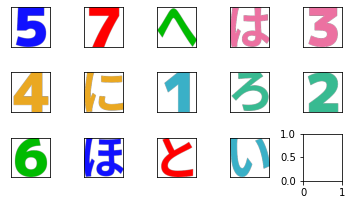

CPU times: user 493 ms, sys: 21.3 ms, total: 515 ms
Wall time: 351 ms


In [21]:
%%time

xlen = math.ceil(len(emoji_ids) / 5)
ylen = 5

fig, ax = plt.subplots(xlen, ylen, figsize=(5, math.ceil(len(emoji_ids) / 5)))
# print(ax.shape)

i = 0
j = 0
for emoji_id in emoji_ids:
    res = mm_emoji_image(emoji_id)
    img = np.array(Image.open(io.BytesIO(res.content)))

    ax[i, j].imshow(img)
    ax[i, j].xaxis.set_visible(False)
    ax[i, j].yaxis.set_visible(False)
    j += 1
    if j == ylen:
        j = 0
        i += 1
    if 0 < j and j % 10 == 0:
        # 10アクセスごとに1秒sleep
        sleep(1)
        
plt.tight_layout()
plt.show()
plt.close()
